# import module

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import re #파이썬에서 정규 표현식을 지원하는 모듈
warnings.filterwarnings(action = "ignore")

# Load files

In [3]:
olist_order_reviews = pd.read_csv("./data/olist_order_reviews_dataset_translate.csv")

# Data 확인

In [4]:
df_comments = olist_order_reviews[["review_score","review_comment_msg_en"]]
df_comments = df_comments.dropna(subset = ["review_comment_msg_en"], axis = 0)
df_comments = df_comments.reset_index(drop = True)
print(f"Dataset shape : {df_comments.shape}")
df_comments.columns = ["score","comment_eng"]
df_comments.head()

Dataset shape : (41717, 2)


,score,comment_eng
0,5,I received well before the stipulated deadline.
1,5,Congratulations LANNISTER stores I loved to bu...
2,4,efficient device. on the site the mark of the ...
3,4,"But a little, catching ... for the value is go..."
4,5,"Reliable seller, product ok and delivery befor..."


# 텍스트 마이닝
- https://dschloe.github.io/python/nlp/ch01_text_mining/

In [5]:
df_comments[df_comments.score==1]["comment_eng"]

6                                                Terrible 
11                    Did not like ! I bought cat by hare 
12       I always buy the Internet and delivery occurs ...
17                             Nothing to get my request. 
22       I received only 1 Midea Split style control.  ...
                               ...                        
41686    Until today 21/10/2017 the request was not del...
41693    I received the following email and I need to k...
41699                                      Good afternoon.
41715    I requested the purchase of a Celtic / Prism /...
41716    My product arrived and I already have to retur...
Name: comment_eng, Length: 9176, dtype: object

## 문장 토큰화

In [6]:
from nltk import sent_tokenize #문장 토큰화
from nltk import word_tokenize #단어 토큰화
import nltk

In [7]:
#마침표, 개행문자(ex, \n)_ 등의 데이터 세트 다운
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ChangYong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
text_sample = df_comments.comment_eng[0]

In [9]:
text_sample

'I received well before the stipulated deadline. '

In [10]:
sentences = sent_tokenize(text = text_sample)
print(type(sentences), len(sentences))
print(sentences)
#해당 comment는 한 개의 문장으로 된 문자열이다

<class 'list'> 1
['I received well before the stipulated deadline.']


## 단어 토큰화

- 문장의 단어로 토큰화하는 것을 말하며, 기본적으로 공백, 콤마, 마침표, 개행문자 등으로 단어를 분리하지만, 정규 표현식을 이용해 다양한 유형으로 토큰화를 수행할 수 있음
- 단어의 순서가 중요하지 않는 경우에는 bag of word를 사용해도 무방함


In [11]:
sentence = sentences.copy()
words = word_tokenize(text = sentence[0])
print(type(words), len(words))
print(sentence)
print(words)

<class 'list'> 8
['I received well before the stipulated deadline.']
['I', 'received', 'well', 'before', 'the', 'stipulated', 'deadline', '.']


## 문장 & 단어 토큰화 함수 구현

- for loop 활용을 위해 문장 및 단어를 토큰화 하는 코드 구현

In [12]:
def tokenize_text(text, lang = 'english'):
    """
    text를 문장 및 단어 토큰화하여 반환
    text : string type
    language : 입력한 text type
    """
    sentences = sent_tokenize(text = text,language= lang)
    word_tokens = [word_tokenize(text = sentence, language= lang) for sentence in sentences]
    return word_tokens

In [13]:
text_sample = df_comments.comment_eng[12]
word_tokens = tokenize_text(text_sample)
print(type(word_tokens),len(word_tokens))
print(word_tokens)

<class 'list'> 2
[['I', 'always', 'buy', 'the', 'Internet', 'and', 'delivery', 'occurs', 'before', 'the', 'combined', 'deadline', ',', 'which', 'I', 'believe', 'is', 'the', 'maximum', 'period', '.'], ['In', 'Stark', 'the', 'maximum', 'period', 'has', 'already', 'been', 'exhausted', 'and', 'I', 'have', 'not', 'received', 'the', 'product', 'yet', '.']]


- 입력한 text의 문장별 각각의 리스트로 출력이 되고, 각 리스트는 문장에 대한 토큰화된 단어를 요소로 가짐
- 문장을 토큰화하면 문맥적 의미 해석이 문제가 되는데, 이러한 문제 해결을 위해 도입된 개념이 n-gram
---
N-Gram : 연속된 n 개의 단어를 하나의 토큰화 단위로 분리해 내는 것
- ex) I love you
- (I, love), (love, you)

## 텍스트 전처리 - 스톱 워드(불용어) 처리

- 의미가 없는 be 동사 등을 제거할 때 사용
    - 이런 단어들은 매우 자주 나타나는 경향이 있음
- NTLK의 스톱 워드에 기본적인 세팅이 저장되어 있음

In [14]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ChangYong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
# 영어 불용어 개수 확인
print("영어 불용어 개수 : ",len(nltk.corpus.stopwords.words("english")))

영어 불용어 개수 :  179


- 불용어를 필터링하여 분석을 위한 의미있는 단어만 추출
- 3개의 문장별로 얻은 word_tokens list에 대해 불용어 제거하는 반복문 작성

In [16]:
stopwords = nltk.corpus.stopwords.words("english")
all_token = []

for sentence in word_tokens:
    #빈 리스트 생성
    filtered_words = []
    
    #개별 문장별로 토큰화된 문장 list에 대해 불용어 제거
    for word in sentence:
        
        #소문자로 변환
        word = word.lower()
        
        #토큰화된 개별 단어가 불용어에 포함되지 않으면 word_tokens에 추가
        if word not in stopwords:
            filtered_words.append(word)
    all_token.append(filtered_words)

print(f"불용어 처리 전 : \n{word_tokens}")
print("\n")
print(f"불용어 처리 후 : \n{all_token}")

불용어 처리 전 : 
[['I', 'always', 'buy', 'the', 'Internet', 'and', 'delivery', 'occurs', 'before', 'the', 'combined', 'deadline', ',', 'which', 'I', 'believe', 'is', 'the', 'maximum', 'period', '.'], ['In', 'Stark', 'the', 'maximum', 'period', 'has', 'already', 'been', 'exhausted', 'and', 'I', 'have', 'not', 'received', 'the', 'product', 'yet', '.']]


불용어 처리 후 : 
[['always', 'buy', 'internet', 'delivery', 'occurs', 'combined', 'deadline', ',', 'believe', 'maximum', 'period', '.'], ['stark', 'maximum', 'period', 'already', 'exhausted', 'received', 'product', 'yet', '.']]


## 텍스트 전처리 - 어간(Stemming) 및 표제어(Lemmatization)

- 동사 변환 : love, loved, loving
- 어근 및 표제어는 단어의 원형을 찾는 것
- 근데, 표제어 추출이 어근보다는 보다 더 의미로적 기반에서 단어의 원형을 찾음

### 어간(stemming)
***
- 원형 단어로 변환 시 어미를 제거하는 방식 사용( worked => work)
- stemming 기법에는 크게 Porter, Lancaster, Snowball Stemmer 가 있음
- 이 중 Lancaster stemmer가 간단하지만 over-stemming하는 경향이 있으므로 Porter Stemmer를 사용함

In [17]:
porter = nltk.stem.PorterStemmer()
lancaster = nltk.stem.LancasterStemmer()
snowball = nltk.stem.SnowballStemmer("english")

print("{0:10}{1:20}{2:20}{3:20}".format("Word","Porter Stemmer","lancaster Stemmer","Snowball Stemmer"))
for sentence in all_token:
    for word in sentence:
        print("{0:10}{1:20}{2:20}{3:20}".format(word, porter.stem(word),lancaster.stem(word), snowball.stem(word)))

Word      Porter Stemmer      lancaster Stemmer   Snowball Stemmer    
always    alway               alway               alway               
buy       buy                 buy                 buy                 
internet  internet            internet            internet            
delivery  deliveri            delivery            deliveri            
occurs    occur               occ                 occur               
combined  combin              combin              combin              
deadline  deadlin             deadlin             deadlin             
,         ,                   ,                   ,                   
believe   believ              believ              believ              
maximum   maximum             maxim               maximum             
period    period              period              period              
.         .                   .                   .                   
stark     stark               stark               stark               
maximu

### 표제어(Lemmatization)

- 품사와 같은 무법적인 요소와 더 의미적인 부분을 감안하여 정확한 철자로 된 어근 단어를 찾아줌
- 어근을 보통 lemma라고 부르며, 이 때의 어근은 Canoical Form, Ditionary Form, Citation Form이라고 함  
    ex) loves, loved, loving => love에서 파생된 것이며, 여기서 lemma : love

In [18]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ChangYong\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
lemma = nltk.stem.WordNetLemmatizer()

print("{0:10}{1:20}".format("Word","lemma"))
for sentence in all_token:
    for word in sentence:
        print("{0:10}{1:20}".format(word, lemma.lemmatize(word)))

Word      lemma               
always    always              
buy       buy                 
internet  internet            
delivery  delivery            
occurs    occurs              
combined  combined            
deadline  deadline            
,         ,                   
believe   believe             
maximum   maximum             
period    period              
.         .                   
stark     stark               
maximum   maximum             
period    period              
already   already             
exhausted exhausted           
received  received            
product   product             
yet       yet                 
.         .                   


## 자동화

In [20]:
def tokenize_text(text, lang = 'english'):
    """
    text를 문장 및 단어 토큰화하여 반환
    text : string type
    language : 입력한 text type
    """
    sentences = sent_tokenize(text = text,language= lang)
    word_tokens = [word_tokenize(text = sentence, language= lang) for sentence in sentences]
    return word_tokens

In [21]:
stopwords = nltk.corpus.stopwords.words("english")

def remove_stopwords(word_tokens):
    """
    and, he, 등과 같은 불용어 제거
    """
    word_tokens = word_tokens
    all_token = []

    #빈 리스트 생성
    filtered_words = []

    #개별 문장별로 토큰화된 문장 list에 대해 불용어 제거
    for word in word_tokens:

        #소문자로 변환
        word = word.lower()

        #토큰화된 개별 단어가 불용어에 포함되지 않으면 word_tokens에 추가
        if word not in stopwords:
            filtered_words.append(word)
    all_token.append(filtered_words)
    return all_token[0]

In [22]:
from sklearn.feature_extraction.text import CountVectorizer #사용자가 직정 정의한 불용어 처리
porter = nltk.stem.PorterStemmer()
lancaster = nltk.stem.LancasterStemmer()
snowball = nltk.stem.SnowballStemmer("english")
lemma = nltk.stem.WordNetLemmatizer()

df_comments["text_tokens"] = np.nan
df_comments["stem_porter"] = np.nan
df_comments["stem_lancaster"] = np.nan
df_comments["stem_snowball"] = np.nan
df_comments["lemma"] = np.nan

for i,comment in enumerate(df_comments.comment_eng):
    if i%500==0:
        print(f"[ {(i+1)/len(df_comments.comment_eng)*100:.0f}% ] {i} 번째 index 진행 중")
    elif (i+1)==len(df_comments.comment_eng):
        print("end")
    
    #토큰화
    sentences = tokenize_text(comment, lang = 'english')
    
    #불용어 처리
    #stemming & lemmatization 결과를 저장할 리스트 객체 생성
    words_token = []
    porter_result = []
    lancaster_result = []
    snowball_result = []
    lemma_result = []
    for sentence in sentences:
        #불용어 처리
        sentence = remove_stopwords(sentence)
        
        for word in sentence:
            #단어 중 특수문자로 된 경우 제거
            if (re.search(r'[a-zA-Z]',word)!=None) & (len(word)>2):
                word = re.sub(r'[^A-Za-z]', '', word).lower()# 문자열 중 특수문자 제거
                words_token.append(word)
                porter_result.append(porter.stem(word))
                lancaster_result.append(lancaster.stem(word))
                snowball_result.append(snowball.stem(word))
                lemma_result.append(lemma.lemmatize(word))
            
    #dataframe에 리스트 객체 저장
    df_comments["text_tokens"][i] = words_token
    df_comments["stem_porter"][i] = porter_result
    df_comments["stem_lancaster"][i] = lancaster_result
    df_comments["stem_snowball"][i] = snowball_result
    df_comments["lemma"][i] = lemma_result

[ 0% ] 0 번째 index 진행 중
[ 1% ] 500 번째 index 진행 중
[ 2% ] 1000 번째 index 진행 중
[ 4% ] 1500 번째 index 진행 중
[ 5% ] 2000 번째 index 진행 중
[ 6% ] 2500 번째 index 진행 중
[ 7% ] 3000 번째 index 진행 중
[ 8% ] 3500 번째 index 진행 중
[ 10% ] 4000 번째 index 진행 중
[ 11% ] 4500 번째 index 진행 중
[ 12% ] 5000 번째 index 진행 중
[ 13% ] 5500 번째 index 진행 중
[ 14% ] 6000 번째 index 진행 중
[ 16% ] 6500 번째 index 진행 중
[ 17% ] 7000 번째 index 진행 중
[ 18% ] 7500 번째 index 진행 중
[ 19% ] 8000 번째 index 진행 중
[ 20% ] 8500 번째 index 진행 중
[ 22% ] 9000 번째 index 진행 중
[ 23% ] 9500 번째 index 진행 중
[ 24% ] 10000 번째 index 진행 중
[ 25% ] 10500 번째 index 진행 중
[ 26% ] 11000 번째 index 진행 중
[ 28% ] 11500 번째 index 진행 중
[ 29% ] 12000 번째 index 진행 중
[ 30% ] 12500 번째 index 진행 중
[ 31% ] 13000 번째 index 진행 중
[ 32% ] 13500 번째 index 진행 중
[ 34% ] 14000 번째 index 진행 중
[ 35% ] 14500 번째 index 진행 중
[ 36% ] 15000 번째 index 진행 중
[ 37% ] 15500 번째 index 진행 중
[ 38% ] 16000 번째 index 진행 중
[ 40% ] 16500 번째 index 진행 중
[ 41% ] 17000 번째 index 진행 중
[ 42% ] 17500 번째 index 진행 중
[ 43% ] 18000 번째 index 진

# word cloud

## score별 dataset 생성

In [23]:
df_comments_1 = df_comments[df_comments.score==1].reset_index(drop=True)
df_comments_2 = df_comments[df_comments.score==2].reset_index(drop=True)
df_comments_3 = df_comments[df_comments.score==3].reset_index(drop=True)
df_comments_4 = df_comments[df_comments.score==4].reset_index(drop=True)
df_comments_5 = df_comments[df_comments.score==5].reset_index(drop=True)

## score별 단어 모으기

In [24]:
words = ['text_tokens','stem_porter','stem_lancaster','stem_snowball','lemma']

In [25]:
#어떤 텍스트로 진행할 지 선택
# 0 : 원본 단어 토큰, 1: portstemmer 추출, 2:lancasterstmmer 추출, 3. snowballstemmer추출, 4. lemmatization
word = words[0]

score_1_words = [word for sentence in df_comments_1[word] for word in sentence]
score_2_words = [word for sentence in df_comments_2[word] for word in sentence]
score_3_words = [word for sentence in df_comments_3[word] for word in sentence]
score_4_words = [word for sentence in df_comments_4[word] for word in sentence]
score_5_words = [word for sentence in df_comments_5[word] for word in sentence]

## score별 단어 개수 세기

In [26]:
from collections import Counter
score_1_word_count = Counter(score_1_words)
score_2_word_count = Counter(score_2_words)
score_3_word_count = Counter(score_3_words)
score_4_word_count = Counter(score_4_words)
score_5_word_count = Counter(score_5_words)

## score별 top n개 보기

In [27]:
n = 50
score_1_top_50_words = score_1_word_count.most_common(n)
score_2_top_50_words = score_2_word_count.most_common(n)
score_3_top_50_words = score_3_word_count.most_common(n)
score_4_top_50_words = score_4_word_count.most_common(n)
score_5_top_50_words = score_5_word_count.most_common(n)

## 상기 과정 함수화 및 시각화 자료 생성

In [28]:
from wordcloud import WordCloud

In [29]:
def wordcloud_by_dict_data(data, k = 0,n=50):
    """
    dict type 데이터로 word cloud 생성
    data = dataframe
    k = 0: 원본 단어 토큰(default)  
        1: portstemmer 추출  
        2: lancasterstmmer 추출  
        3: snowballstemmer추출  
        4: lemmatization  
        
    n = 생성할 words 개수
    """
    words = ['text_tokens','stem_porter','stem_lancaster','stem_snowball','lemma']
    
    #dataframe에서 각 행마다 문장별 리스트 형태로 되어있으므로 단어별로 대체
    data_word = [word for sentence in data[words[k]] for word in sentence]
    
    #단어별 개수 세기
    word_count_sorted = Counter(data_word)
    
    #카운트 횟수가 상위 n개인 단어 추출
    words = word_count_sorted.most_common(n)
    
    #워드클라우드
    tmp = WordCloud(font_path='c:/windows/fonts/Gothic.ttf',
    #                       width = 1000,
    #                       height = 1000,
                          max_words = n,
                          max_font_size = 300,
                          background_color='white').generate_from_frequencies(dict(words))
    return tmp

Text(0.5, 1.0, 'score_5')

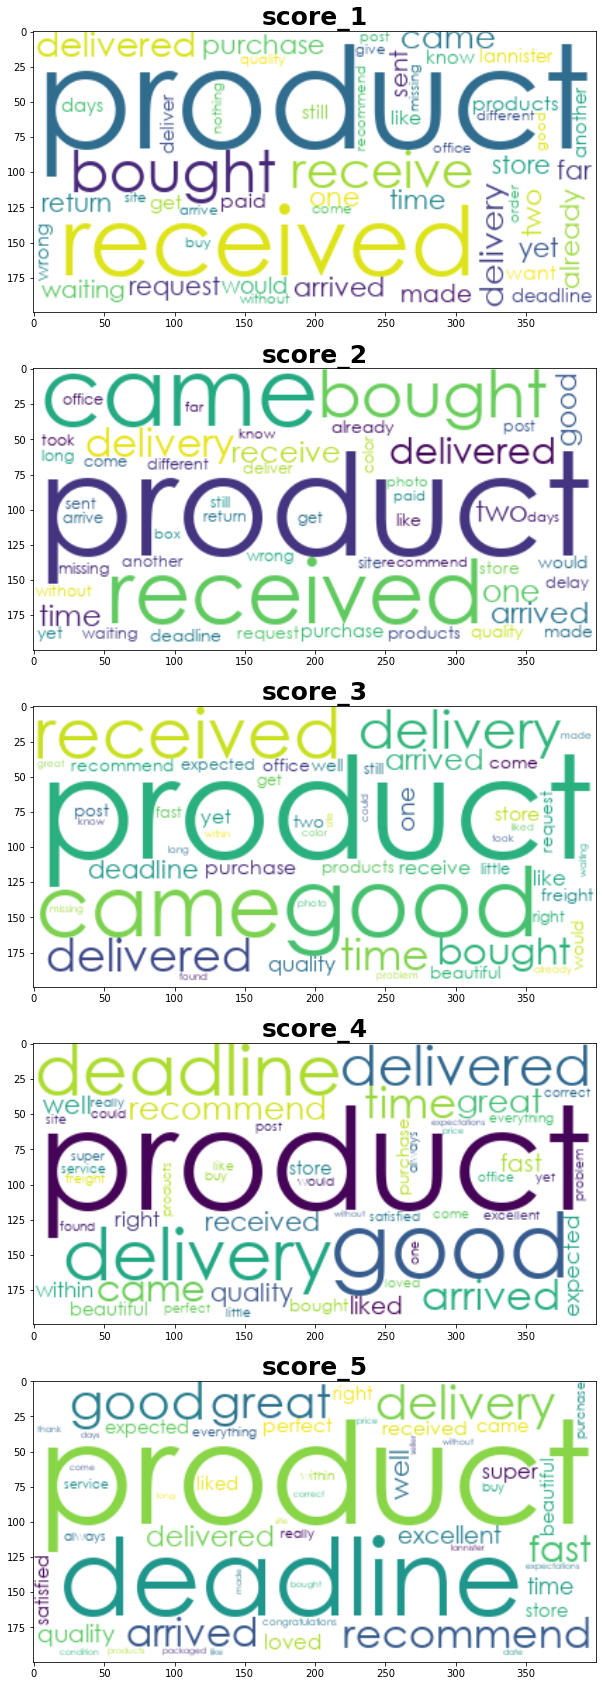

In [31]:
k = 0
score_1_word_cloud = wordcloud_by_dict_data(df_comments_1,k = k, n = 50)
score_2_word_cloud = wordcloud_by_dict_data(df_comments_2,k = k, n = 50)
score_3_word_cloud = wordcloud_by_dict_data(df_comments_3,k = k, n = 50)
score_4_word_cloud = wordcloud_by_dict_data(df_comments_4,k = k, n = 50)
score_5_word_cloud = wordcloud_by_dict_data(df_comments_5,k = k, n = 50)

fig,ax = plt.subplots(5,1,figsize=(20, 30))
ax[0].imshow(score_1_word_cloud, interpolation="bilinear")
ax[1].imshow(score_2_word_cloud, interpolation="bilinear")
ax[2].imshow(score_3_word_cloud, interpolation="bilinear")
ax[3].imshow(score_4_word_cloud, interpolation="bilinear")
ax[4].imshow(score_5_word_cloud, interpolation="bilinear")

ax[0].set_title("score_1", fontsize = 25, fontweight = "bold", fontfamily = "Sans Serif")
ax[1].set_title("score_2", fontsize = 25, fontweight = "bold", fontfamily = "Sans Serif")
ax[2].set_title("score_3", fontsize = 25, fontweight = "bold", fontfamily = "Sans Serif")
ax[3].set_title("score_4", fontsize = 25, fontweight = "bold", fontfamily = "Sans Serif")
ax[4].set_title("score_5", fontsize = 25, fontweight = "bold", fontfamily = "Sans Serif")

# score_1_word_cloud.to_file('score_1_word_cloud.png')
# score_2_word_cloud.to_file('score_2_word_cloud.png')
# score_3_word_cloud.to_file('score_3_word_cloud.png')
# score_4_word_cloud.to_file('score_4_word_cloud.png')
# score_5_word_cloud.to_file('score_5_word_cloud.png')